>[Q3: KNN classifier & metric-learning](#scrollTo=dbgBZutQGCn4)

>>[A & B: Implement KNN classifier](#scrollTo=SFgZGHRWGQJj)

>>[C: Metric-learning](#scrollTo=xCrNBgfkI3-R)

>>[D: Correlation Matrix](#scrollTo=Weo38-vvOLXe)



# Q3: KNN classifier & metric-learning

In [ ]:
!pip install -q metric-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from metric_learn import LMNN
from metric_learn import LFDA
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap

## A & B: Implement KNN classifier

In [ ]:
dataset = load_wine()
data = dataset['data']
target = dataset['target']
data = pd.DataFrame(data)
label = pd.DataFrame(target, columns=['label'])

In [ ]:
df = pd.concat([data, label], axis=1)
mask = np.random.rand(len(df)) <= 0.8
train = df[mask].reset_index(drop=True)
y_train = train['label']
X_train = train.drop(['label'], axis=1)
test = df[~mask].reset_index(drop=True)
y_test = test['label']
X_test = test.drop(['label'], axis=1)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.probs = []
        self.l = []

    def fit(self, X_train, y_train):
        self.X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
        self.y_train = y_train.to_numpy() if isinstance(y_train, pd.DataFrame) else y_train

    def predict(self, X_test, y_test):
        true_prob = {}
        false_prob = {}
        self.X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
        self.y_test = y_test.to_numpy() if isinstance(y_test, pd.DataFrame) else y_test

        labels = np.array([self._predict(x,y) for x,y in zip(self.X_test, self.y_test)])
        self.result = pd.DataFrame({"Probability": self.probs, "Label": self.l})
        return labels

    def _predict(self, x, y):

        distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        neighbor_count = np.bincount(k_nearest_labels, minlength=np.max(self.y_train)+1)
        label = neighbor_count.argmax()

        prob = neighbor_count.max()/self.k
        self.probs.append(prob)
        self.l.append("TRUE") if label == y else self.l.append("FALSE")

        return label

In [ ]:
def confusion_matrix(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    matrix = [[0] * num_classes for _ in range(num_classes)]

    for true, pred in zip(y_true, y_pred):
        matrix[true][pred] += 1

    return np.array(matrix)


def precision(y_true, y_pred):

    classes = list(set(y_true))

    precision_dict = {}
    for class_label in classes:
        true_positives = sum((y_true == class_label) & (y_pred == class_label))
        false_positives = sum((y_true != class_label) & (y_pred == class_label))

        if true_positives + false_positives == 0:
            precision_value = 0.0
        else:
            precision_value = true_positives / (true_positives + false_positives)

        precision_dict[class_label] = round(precision_value, 2)

    return pd.DataFrame.from_dict(precision_dict, orient='index', columns=["Precision"])

**K = 1 (One nearest neighbor)**

   Precision
0       0.75
1       0.72
2       0.56


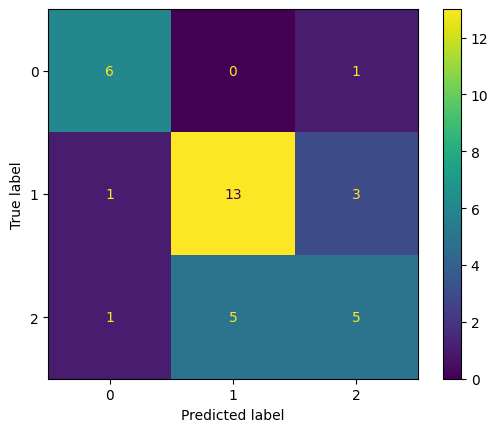

In [ ]:
knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test, y_test)

print(precision(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
plt.show()

**K = [5, 10, 20]**

In [ ]:
def plot_graph(result, k,i):
    sns.countplot(data=result, x = 'Label', hue = 'Probability', ax=axs[0,i])
    axs[0,i].legend(bbox_to_anchor=(1.2,1), loc='upper right', borderaxespad=0)
    axs[0,i].set_title(f"K={k}")

K=5

   Precision
0       0.75
1       0.72
2       0.56

K=10

   Precision
0       0.71
1       0.60
2       0.38

K=20

   Precision
0       0.71
1       0.68
2       0.56



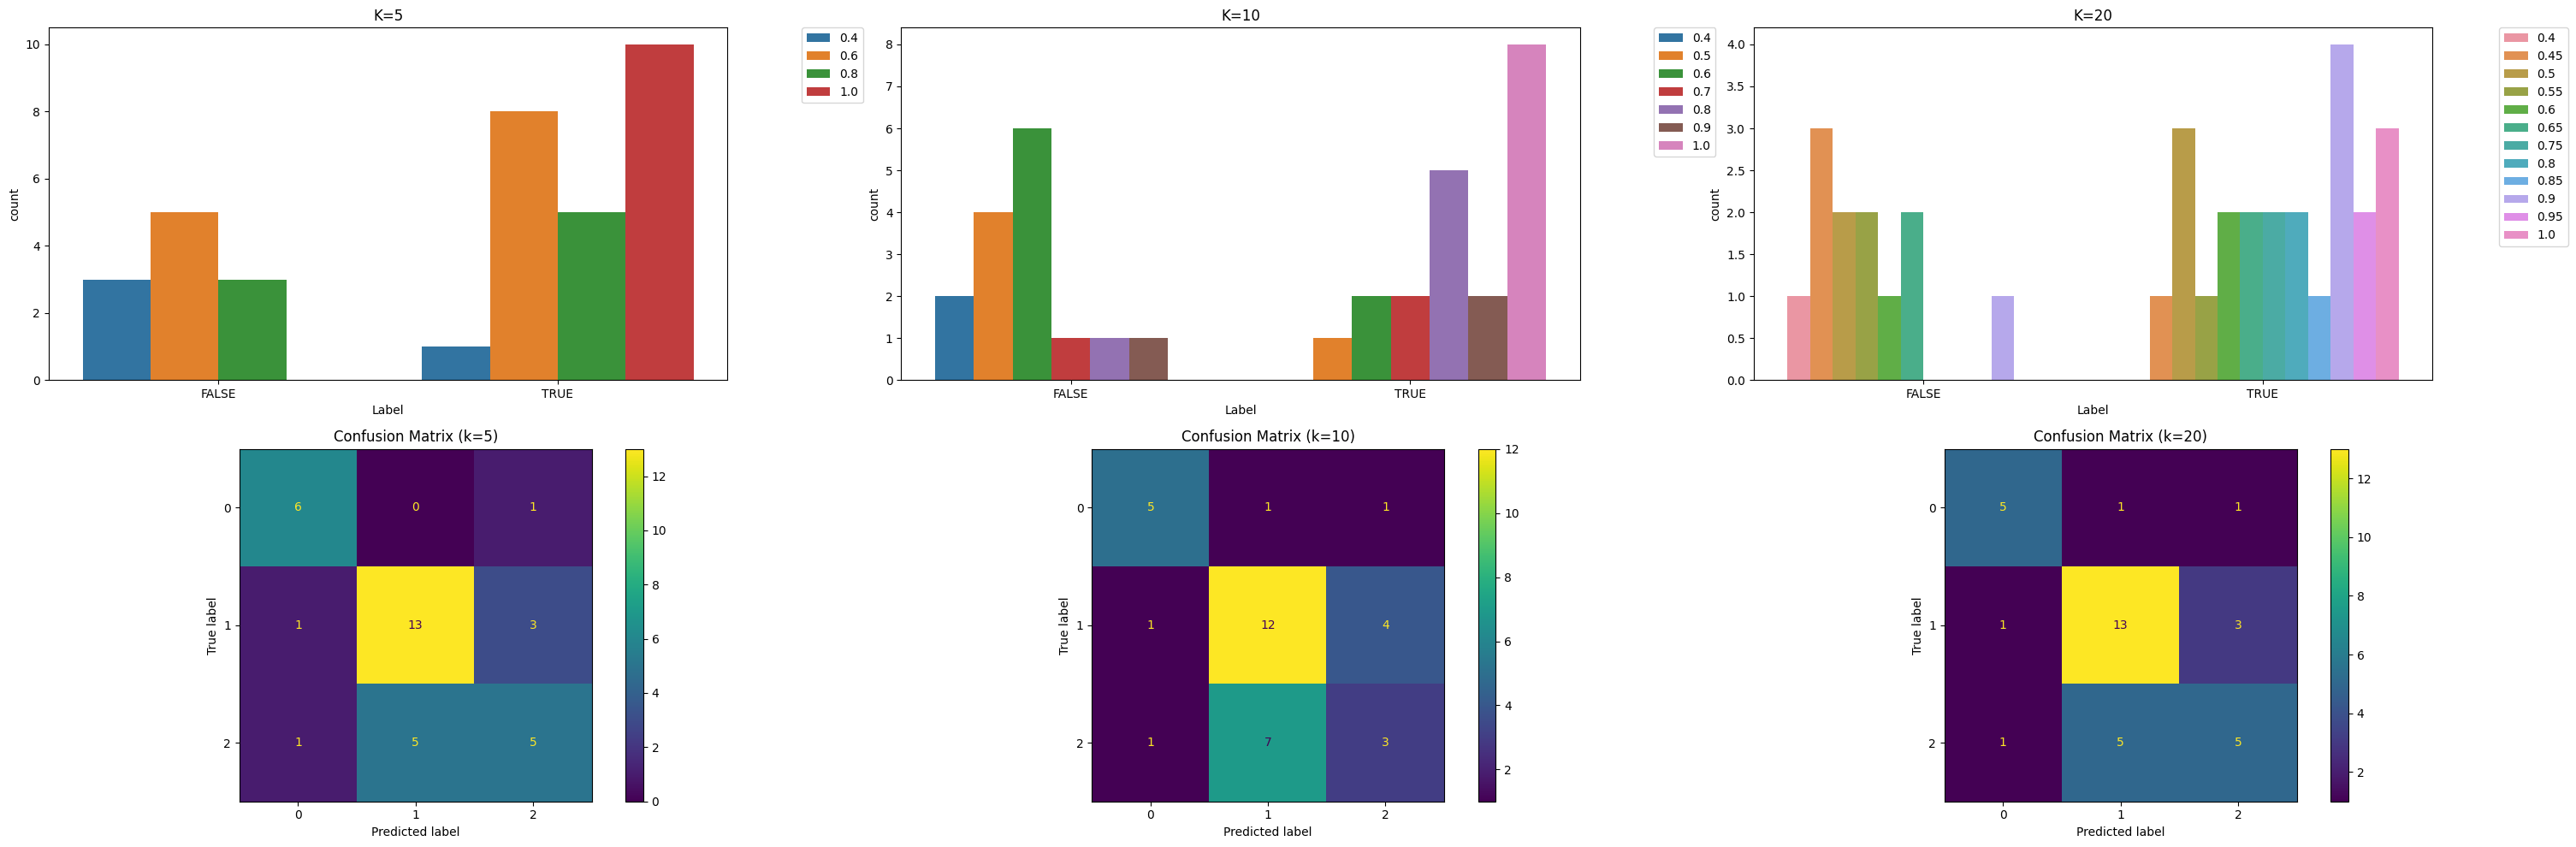

In [ ]:
K = np.array([5, 10, 20])

fig, axs = plt.subplots(2, 3, figsize=(30, 10))
for i, k in enumerate(K):
  knn_classifier = KNNClassifier(k=k)
  knn_classifier.fit(X_train, y_train)
  y_pred = knn_classifier.predict(X_test, y_test)
  probs = knn_classifier.result
  print(f"K={k}\n")
  print(f"{precision(y_test, y_pred)}\n")

  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
  disp.plot(ax=axs[1, i])
  axs[1, i].set_title(f"Confusion Matrix (k={k})")

  plot_graph(probs,k,i)

plt.tight_layout()
plt.show()

## C: Metric-learning

**LMNN**

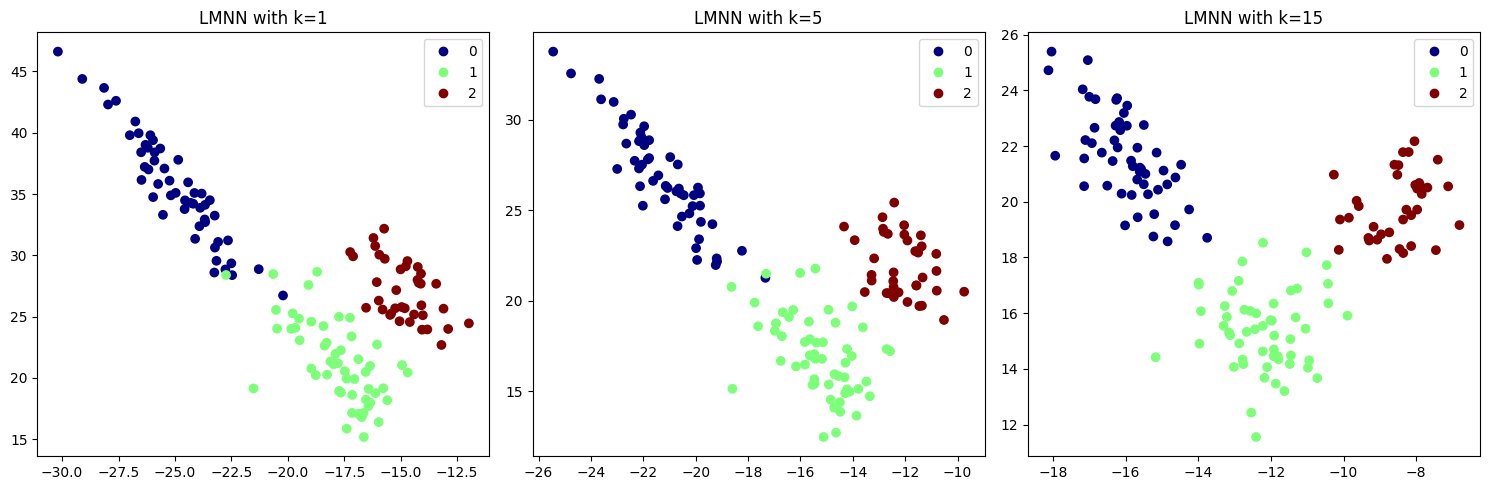

In [ ]:
K = [1, 5, 15]
X_train_LMNN={}
X_test_LMNN={}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, k in enumerate(K):
  lmnn = LMNN(init="lda",n_components=2, n_neighbors=k)
  lmnn.fit(X_train, y_train)
  X_train_LMNN[k] = lmnn.transform(X_train)
  X_test_LMNN[k] = lmnn.transform(X_test)

  scatter = axs[i].scatter(X_train_LMNN[k][:,0], X_train_LMNN[k][:,1],c=y_train, cmap="jet")
  axs[i].set_title(f"LMNN with k={k}")
  axs[i].legend(handles=scatter.legend_elements()[0], labels=["0","1","2"])

plt.tight_layout()
plt.show()

k=1

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.94      0.97        17
           2       1.00      1.00      1.00        11

    accuracy                           0.97        35
   macro avg       0.96      0.98      0.97        35
weighted avg       0.97      0.97      0.97        35


k=5

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.94      0.97        17
           2       1.00      1.00      1.00        11

    accuracy                           0.97        35
   macro avg       0.96      0.98      0.97        35
weighted avg       0.97      0.97      0.97        35


k=10

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.94      0.97        17
           2       1.00      1.00      1.00        11

  

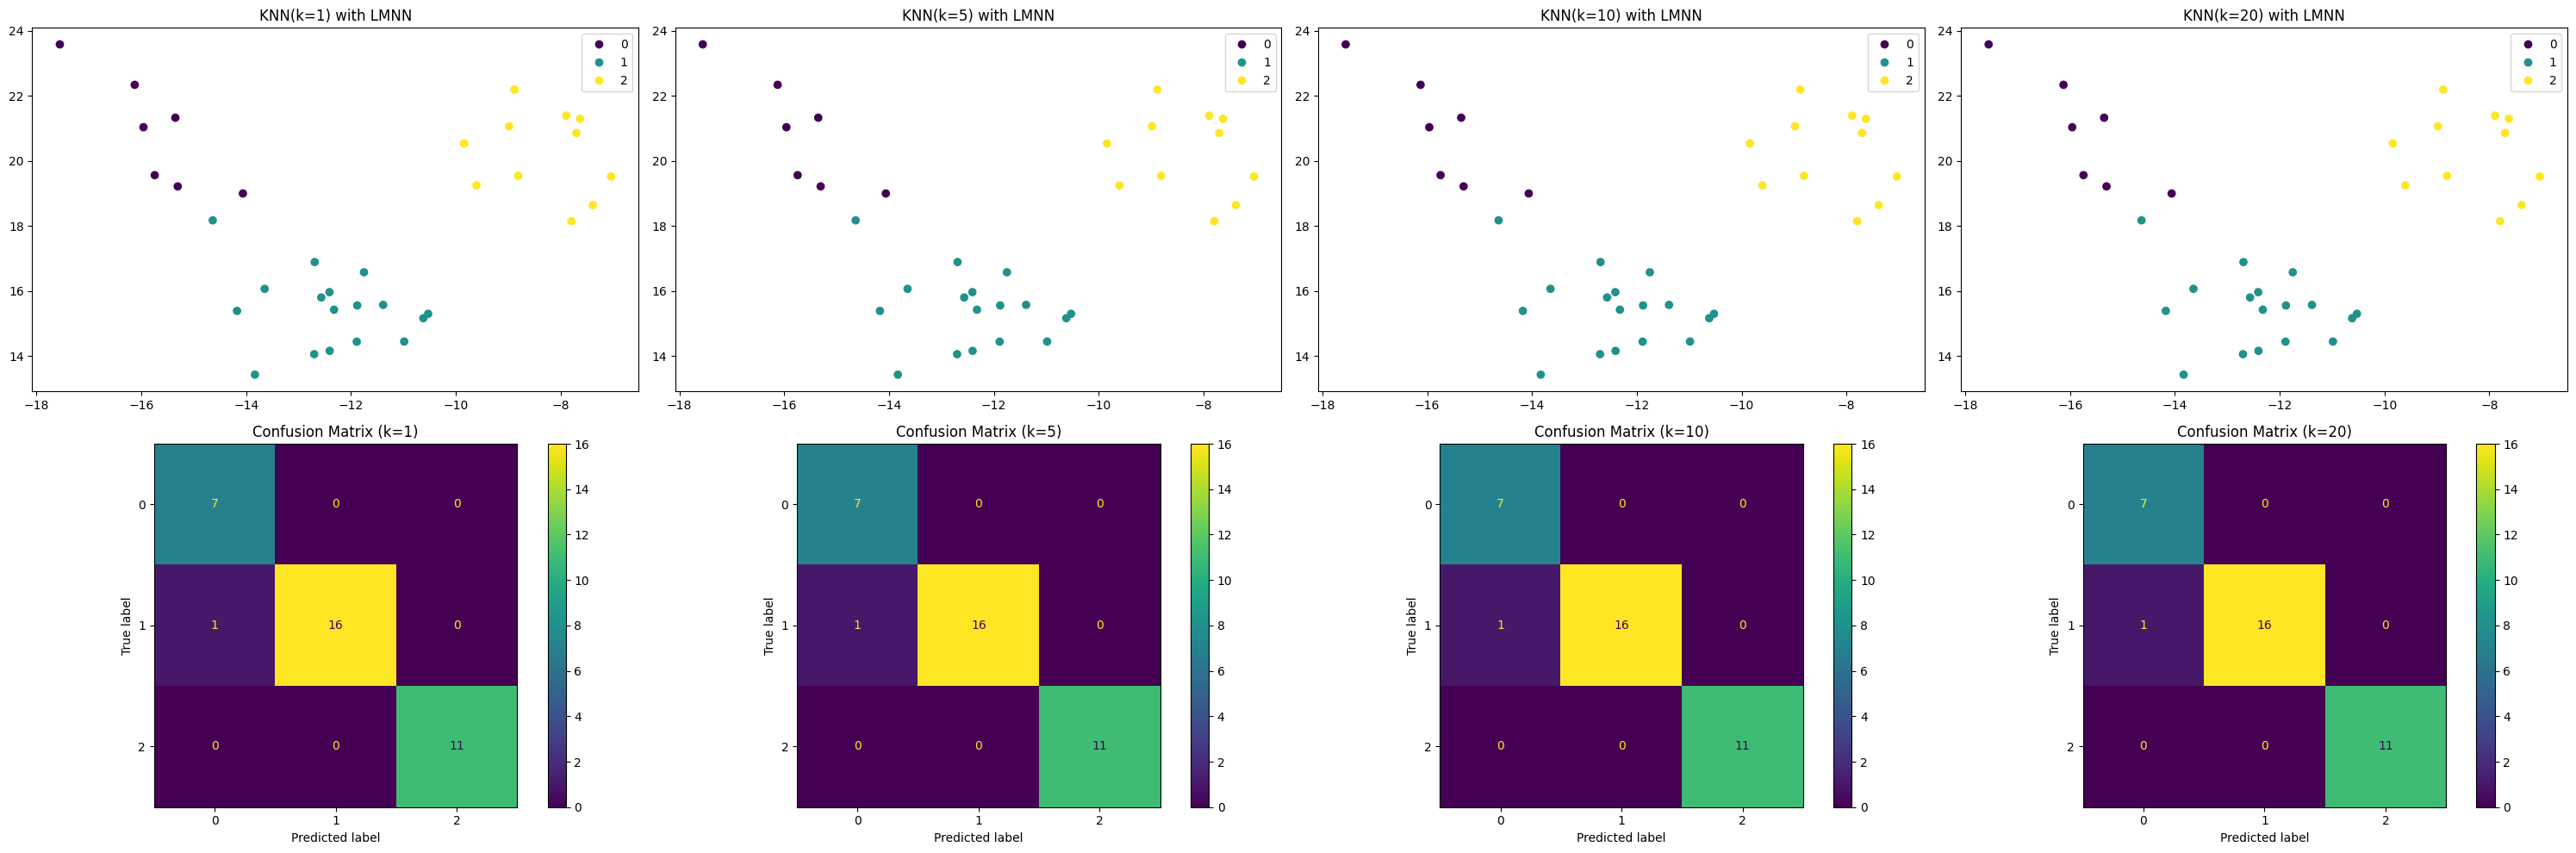

In [ ]:
K = [1,5, 10, 20]
fig, axs = plt.subplots(2, 4, figsize=(30, 10))

for i,k in enumerate(K):
  knn_classifier = KNNClassifier(k=k)
  knn_classifier.fit(X_train_LMNN[15], y_train)
  y_pred = knn_classifier.predict(X_test_LMNN[15], y_test)

  print(f"k={k}\n")
  scatter = axs[0,i].scatter(X_test_LMNN[15][:,0], X_test_LMNN[15][:,1],c=y_test, cmap="viridis")
  axs[0,i].set_title(f"KNN(k={k}) with LMNN")
  axs[0,i].legend(handles=scatter.legend_elements()[0], labels=["0","1","2"])

  print(f"{classification_report(y_test, y_pred)}\n")
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
  disp.plot(ax=axs[1, i])
  axs[1, i].set_title(f"Confusion Matrix (k={k})")

plt.tight_layout()
plt.show()

**LFDA**

/usr/local/lib/python3.10/dist-packages/metric_learn/lfda.py:109: UserWarning: Chosen k (15) too large, using 12 instead.
  warnings.warn('Chosen k (%d) too large, using %d instead.'


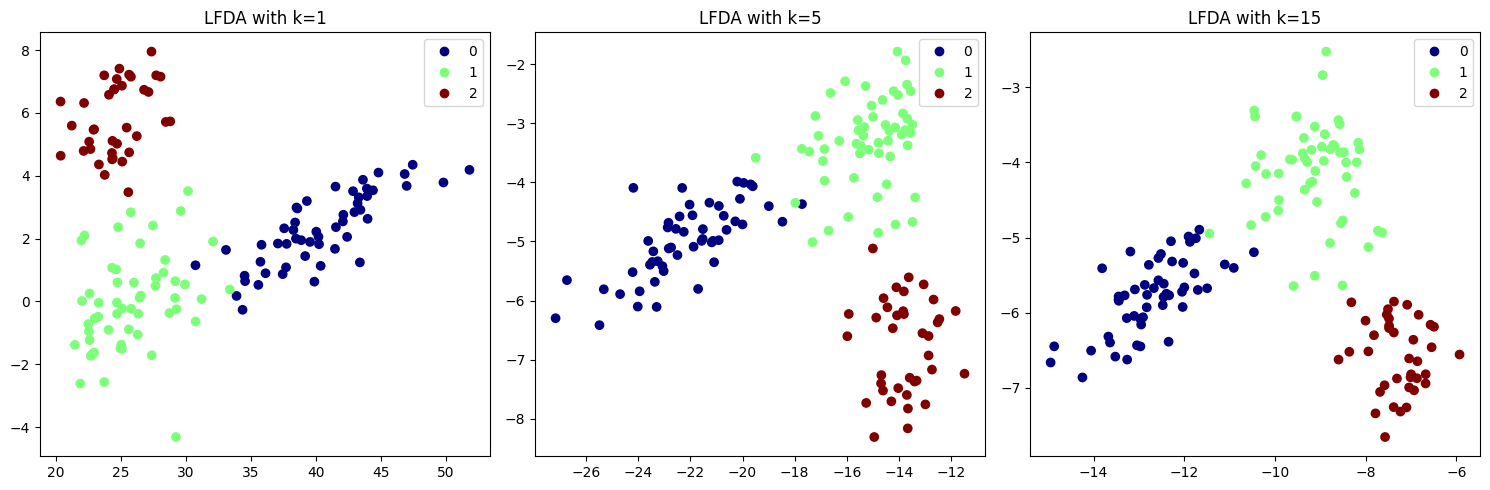

In [ ]:
K = [1, 5, 15]
X_train_LFDA ={}
X_test_LFDA ={}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i,k in enumerate(K):
  lmnn = LFDA(n_components=2, k=k)
  lmnn.fit(X_train, y_train)
  X_train_LFDA[k] = lmnn.transform(X_train)
  X_test_LFDA[k] = lmnn.transform(X_test)

  scatter = axs[i].scatter(X_train_LFDA[k][:,0], X_train_LFDA[k][:,1],c=y_train, cmap="jet")
  axs[i].set_title(f"LFDA with k={k}")
  axs[i].legend(handles=scatter.legend_elements()[0], labels=["0","1","2"])

plt.tight_layout()
plt.show()

k=1

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.94      0.97        17
           2       1.00      1.00      1.00        11

    accuracy                           0.97        35
   macro avg       0.96      0.98      0.97        35
weighted avg       0.97      0.97      0.97        35


k=5

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.94      0.97        17
           2       1.00      1.00      1.00        11

    accuracy                           0.97        35
   macro avg       0.96      0.98      0.97        35
weighted avg       0.97      0.97      0.97        35


k=10

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.94      0.97        17
           2       1.00      1.00      1.00        11

  

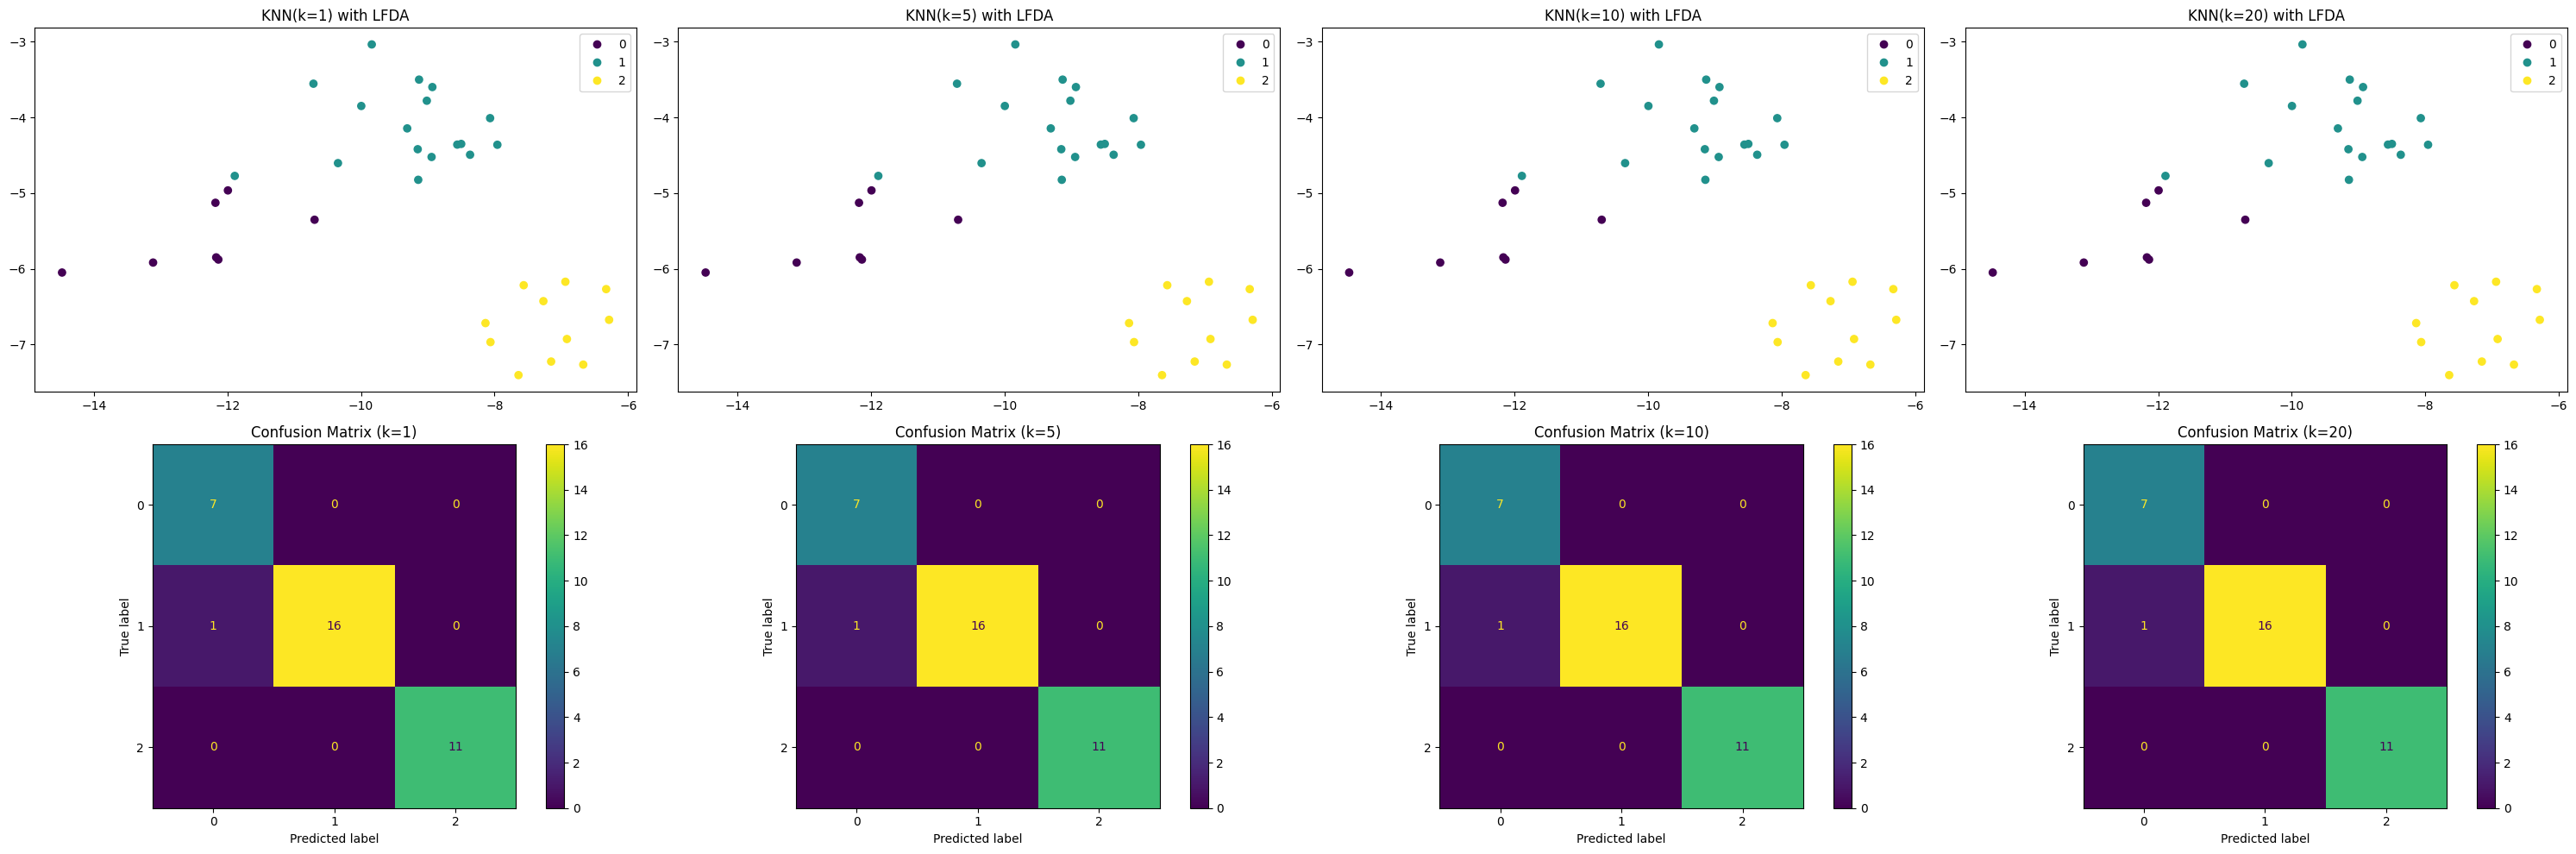

In [ ]:
K = [1,5, 10, 20]
fig, axs = plt.subplots(2, 4, figsize=(30, 10))

for i,k in enumerate(K):
  knn_classifier = KNNClassifier(k=k)
  knn_classifier.fit(X_train_LFDA[15], y_train)
  y_pred = knn_classifier.predict(X_test_LFDA[15], y_test)

  print(f"k={k}\n")
  scatter = axs[0,i].scatter(X_test_LFDA[15][:,0], X_test_LFDA[15][:,1],c=y_test, cmap="viridis")
  axs[0,i].set_title(f"KNN(k={k}) with LFDA")
  axs[0,i].legend(handles=scatter.legend_elements()[0], labels=["0","1","2"])

  print(f"{classification_report(y_test, y_pred)}\n")
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
  disp.plot(ax=axs[1, i])
  axs[1, i].set_title(f"Confusion Matrix (k={k})")

plt.tight_layout()
plt.show()

## D: Correlation Matrix

**LMNN**

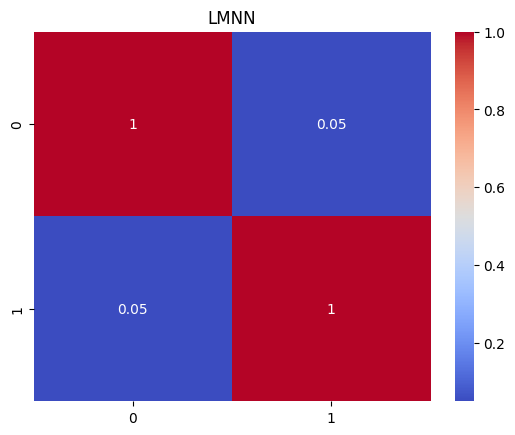

In [ ]:
corr = np.corrcoef(X_test_LMNN[15], rowvar=False)
plt.figure()
sns.heatmap(corr, cmap='coolwarm', xticklabels=True, yticklabels=True, annot=True)
plt.title("LMNN")
plt.show()

**LFDA**

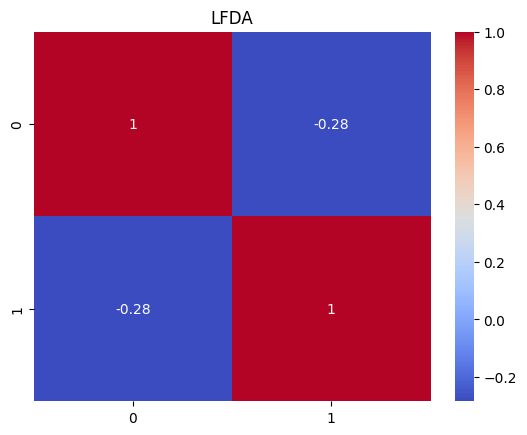

In [ ]:
corr = np.corrcoef(X_test_LFDA[15], rowvar=False)
plt.figure()
sns.heatmap(corr, cmap='coolwarm', xticklabels=True, yticklabels=True, annot=True)
plt.title("LFDA")
plt.show()